In [1]:
from models.transformers import DecoderOnlyTransformer
import torch
from torch.utils.data import DataLoader
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import shutil
import wandb
import yaml
from data.datasets import CFGDataset, verify_dataloader
from trainers.GPT_trainer import GPT_Trainer
from trainers.utils import create_optimizer, create_scheduler
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#Read config yaml file
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
print(f"Config loaded successfully.")


import os
os.system("export WANDB_DIR=\tmp")
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


Using device: cuda
Config loaded successfully.


0

#### Loading Data

In [2]:
train_dataset =  CFGDataset(
    data_file="cfg_sentences_train_cfg_simple.npy", 
    batch_size = config["data"]["batch_size"],
    seq_len = config["data"]["seq_len"],
    eos_token = config["data"]["eos_token"],
    sos_token = config["data"]["sos_token"],
    ) 

val_dataset =  CFGDataset(
    data_file="cfg_sentences_val_cfg_simple.npy", 
    
    batch_size = config["data"]["batch_size"],
    seq_len = config["data"]["seq_len"],
    eos_token = config["data"]["eos_token"],
    sos_token = config["data"]["sos_token"],
    ) 


train_loader = DataLoader(train_dataset, 
                          batch_size = None, 
                          num_workers=config["data"]["NUM_WORKERS"] if device == "cuda" else 0, 
                          pin_memory=True)

val_loader = DataLoader(val_dataset, 
                        batch_size=None, 
                        num_workers=config["data"]["NUM_WORKERS"] if device == "cuda" else 0,
                        pin_memory=True)

verify_dataloader(train_loader)
print("_"*50)
verify_dataloader(val_loader)
#print("="*50)
#print("Verify Validation DataLoader")
#verify_dataloader(val_loader)

Verifying dataloader...
Number of batches:  7573
Total number of tokens:  3.722431e+08


Example batch shapes (shifted, golden):  torch.Size([96, 512]) torch.Size([96, 512])
__________________________________________________
Verifying dataloader...
Number of batches:  76
Total number of tokens:  3.760031e+06
Example batch shapes (shifted, golden):  torch.Size([96, 512]) torch.Size([96, 512])


In [3]:
model_config = {}
model_config = config['model'].copy()

model_config.update({
    'num_classes': config["data"]["vocab_size"] +2 ,#include SOS and EOS tolen
    'seq_len': config["data"]["seq_len"],
    })

model = DecoderOnlyTransformer(**model_config)

for batch in train_loader:
    shifted_transcripts, golden_transcripts = batch
    print("Shape of shifted_transcripts : ", shifted_transcripts.shape)
    print("Shape of golden_transcripts  : ", golden_transcripts.shape)
    break
#model.to(device)
#shifted_transcripts = shifted_transcripts.to(device)
#model_stats = summary(model, input_data=[shifted_transcripts])
#print(model_stats)
print(f"Total parameters in the model: {sum(p.numel() for p in model.parameters()):,}")
#torch._dynamo.config.skip_nnmodule_hook_guards = False
#model = torch.compile(model, mode="default", fullgraph=True)


Shape of shifted_transcripts :  torch.Size([96, 512])
Shape of golden_transcripts  :  torch.Size([96, 512])
Total parameters in the model: 85,063,685


In [4]:

torch.cuda.empty_cache()
gc.collect()
#wandb.finish()
#wandb.login("11902c0c8e2c6840d72bf65f04894b432d85f019")

trainer = GPT_Trainer(
    model = model, 
    config = config,
    config_file = "config.yaml",
    run_name = "full_rope_86_0simple", 
    device = device
)
wandb.watch(trainer.model, log="all")

trainer.optimizer = create_optimizer.create_optimizer(
    model = model, 
    opt_config = config["optimizer"]
)

trainer.scheduler = create_scheduler.create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)
#trainer.load_checkpoint("checkpoint-last-epoch-model.pth")
#plot_lr_schedule(trainer.scheduler, num_epochs=len(train_loader), train_loader=train_loader)

#trainer.load_checkpoint("/ocean/projects/cis250019p/sfragara/lstm/expts/test/checkpoints/checkpoint-best-metric-model.pth")

Using device: cuda


wandb: Currently logged in as: lucasfragara (teamlsfr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0003
├── Weight Decay: 0.01
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0003
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0003
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.98]
    ├── Epsilon: 1e-08
    └── AMSGrad: False


/root/miniconda/envs/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 7573 steps
│   └── Min LR: 1e-08
└── Warmup: Disabled


In [5]:
trainer.best_metric

inf

In [6]:
trainer.model.train()

#trainer._validate_epoch(val_loader)
trainer.train_epoch(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
)

generating
Using default generation config...
Generating with greedy search...


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


wandb metrics being logged:  {'train/ce_loss_token': 1.017858520596327, 'train/perplexity_token': 2.7672622203826904, 'val/ce_loss_token': 0.992996096611023, 'val/perplexity_token': 2.699309825897217, 'learning_rate': 0.00029677208413088737}

📊 Metrics (Epoch 500):
├── TRAIN:
│   ├── ce_loss_token: 1.0179
│   └── perplexity_token: 2.7673
└── VAL:
    ├── ce_loss_token: 0.9930
    └── perplexity_token: 2.6993
└── TRAINING:
    └── learning_rate: 0.000297


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.9808011987468936, 'train/perplexity_token': 2.6665918827056885, 'val/ce_loss_token': 0.9449075032025576, 'val/perplexity_token': 2.572575330734253, 'learning_rate': 0.000287252381557078}

📊 Metrics (Epoch 1000):
├── TRAIN:
│   ├── ce_loss_token: 0.9808
│   └── perplexity_token: 2.6666
└── VAL:
    ├── ce_loss_token: 0.9449
    └── perplexity_token: 2.5726
└── TRAINING:
    └── learning_rate: 0.000287


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.9342526236746329, 'train/perplexity_token': 2.5453104972839355, 'val/ce_loss_token': 0.752105975523591, 'val/perplexity_token': 2.1214630603790283, 'learning_rate': 0.00027184898219225455}

📊 Metrics (Epoch 1500):
├── TRAIN:
│   ├── ce_loss_token: 0.9343
│   └── perplexity_token: 2.5453
└── VAL:
    ├── ce_loss_token: 0.7521
    └── perplexity_token: 2.1215
└── TRAINING:
    └── learning_rate: 0.000272


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.8812407472620959, 'train/perplexity_token': 2.4138927459716797, 'val/ce_loss_token': 0.6537916902452707, 'val/perplexity_token': 1.9228177070617676, 'learning_rate': 0.0002512222187173427}

📊 Metrics (Epoch 2000):
├── TRAIN:
│   ├── ce_loss_token: 0.8812
│   └── perplexity_token: 2.4139
└── VAL:
    ├── ce_loss_token: 0.6538
    └── perplexity_token: 1.9228
└── TRAINING:
    └── learning_rate: 0.000251


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.8354058911303719, 'train/perplexity_token': 2.3057496547698975, 'val/ce_loss_token': 0.6013025641441345, 'val/perplexity_token': 1.8244937658309937, 'learning_rate': 0.00022625634568561269}

📊 Metrics (Epoch 2500):
├── TRAIN:
│   ├── ce_loss_token: 0.8354
│   └── perplexity_token: 2.3057
└── VAL:
    ├── ce_loss_token: 0.6013
    └── perplexity_token: 1.8245
└── TRAINING:
    └── learning_rate: 0.000226


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.7997359663039515, 'train/perplexity_token': 2.2249534130096436, 'val/ce_loss_token': 0.569619070738554, 'val/perplexity_token': 1.7675936222076416, 'learning_rate': 0.00019802163216431568}

📊 Metrics (Epoch 3000):
├── TRAIN:
│   ├── ce_loss_token: 0.7997
│   └── perplexity_token: 2.2250
└── VAL:
    ├── ce_loss_token: 0.5696
    └── perplexity_token: 1.7676
└── TRAINING:
    └── learning_rate: 0.000198


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.7712072873074679, 'train/perplexity_token': 2.1623752117156982, 'val/ce_loss_token': 0.5503923092037439, 'val/perplexity_token': 1.7339332103729248, 'learning_rate': 0.00016772848006754032}

📊 Metrics (Epoch 3500):
├── TRAIN:
│   ├── ce_loss_token: 0.7712
│   └── perplexity_token: 2.1624
└── VAL:
    ├── ce_loss_token: 0.5504
    └── perplexity_token: 1.7339
└── TRAINING:
    └── learning_rate: 0.000168


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.7477624774038777, 'train/perplexity_token': 2.1122684478759766, 'val/ce_loss_token': 0.534754840657115, 'val/perplexity_token': 1.7070297002792358, 'learning_rate': 0.0001366755350944571}

📊 Metrics (Epoch 4000):
├── TRAIN:
│   ├── ce_loss_token: 0.7478
│   └── perplexity_token: 2.1123
└── VAL:
    ├── ce_loss_token: 0.5348
    └── perplexity_token: 1.7070
└── TRAINING:
    └── learning_rate: 0.000137


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.7281420459431612, 'train/perplexity_token': 2.0712287425994873, 'val/ce_loss_token': 0.5233748834580183, 'val/perplexity_token': 1.687713861465454, 'learning_rate': 0.00010619401471979542}

📊 Metrics (Epoch 4500):
├── TRAIN:
│   ├── ce_loss_token: 0.7281
│   └── perplexity_token: 2.0712
└── VAL:
    ├── ce_loss_token: 0.5234
    └── perplexity_token: 1.6877
└── TRAINING:
    └── learning_rate: 0.000106


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.7118259998136367, 'train/perplexity_token': 2.0377087593078613, 'val/ce_loss_token': 0.5170539692044258, 'val/perplexity_token': 1.677079677581787, 'learning_rate': 7.759063985567012e-05}

📊 Metrics (Epoch 5000):
├── TRAIN:
│   ├── ce_loss_token: 0.7118
│   └── perplexity_token: 2.0377
└── VAL:
    ├── ce_loss_token: 0.5171
    └── perplexity_token: 1.6771
└── TRAINING:
    └── learning_rate: 0.000078


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.6980360409841172, 'train/perplexity_token': 2.0098016262054443, 'val/ce_loss_token': 0.5130046661943197, 'val/perplexity_token': 1.670302391052246, 'learning_rate': 5.2091616663473e-05}

📊 Metrics (Epoch 5500):
├── TRAIN:
│   ├── ce_loss_token: 0.6980
│   └── perplexity_token: 2.0098
└── VAL:
    ├── ce_loss_token: 0.5130
    └── perplexity_token: 1.6703
└── TRAINING:
    └── learning_rate: 0.000052


[Training LM]:  78%|███████▊  | 5899/7573 [33:48<08:40,  3.22it/s, acc_step=1/1, ce_loss_token=0.6885, lr=0.000035, perplexity_token=1.9907]  

KeyboardInterrupt: 

#### EVAL - Completion Accuracy

In [6]:
from data.grammars import GRAMMAR_CFG3b
from data.CFG_parsers import CFGParser
parser = CFGParser(GRAMMAR_CFG3b)


In [9]:
generation_config = {
                'num_samples': 5,
                'prompt_length': 3,
                'seed': 100,
                #'max_length': self.model.max_len,
                'temperature': 1.0,
                'beam_width': 1,
                'repeat_penalty': 1.0,
                'top_k': 0,
                'top_p': 0.0    
            }
results = trainer.generate(val_loader, generation_config)


Generating with greedy search...


In [10]:
results

[{'prompt': '012',
  'original': '3456789',
  'generated': '3456789',
  'score': 0.0},
 {'prompt': '012',
  'original': '3456789',
  'generated': '3456789',
  'score': 0.0},
 {'prompt': '012',
  'original': '3456789',
  'generated': '3456789',
  'score': 0.0},
 {'prompt': '012',
  'original': '3456789',
  'generated': '3456789',
  'score': 0.0},
 {'prompt': '012',
  'original': '3456789',
  'generated': '3456789',
  'score': 0.0}]

In [ ]:

for res in results: 
    full = res["prompt"] + res["generated"]
    print(full)
    if "5" in full:
        print(parser.is_valid(full[1:full.index("5")-1]))
    else:
        print(parser.is_valid(full[1:-1]))

[{'prompt': '03122112331231213132132321232121312123322131321123323132321312312132131322132123123312213123211232131231313123212112332312123212131312321232132131312312131232321313123121213132123323213213212331212332', 'original': '12132123213131231322132211233213212332132123313232121313231323212112331245555555555555555555555555555555555555555', 'generated': '112331323211231232221313121232113231321123213221121233232131212312312311231213232132132121321323131231212311212132112312', 'score': -29.18068504333496}, {'prompt': '03131221321313121233213123132321313213122131312123312321322131323121312211232132123123312212131312313122132112332123321312321233213213132123312212132123312211232131312123312321323213132313212131231313', 'original': '12321313213123122131312312132321123213123112321312123323212112332321233213221314555555555555555555555555555555555', 'generated': '232131232131212131212312331231321213132313221223131212121213221312313132231213132112321121233122132211233232111331123121', 'score'

### Attention Analysis

In [16]:
checkpoint = torch.load("expts/full_rope_86_0labelsmoothing0.01wdnoweighttying/checkpoints/checkpoint-last-epoch-model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

model.eval()
for i, batch in enumerate(val_loader):
      
            targets_shifted, targets_golden = batch #shape (batch_size, seq_len)
            targets_shifted, targets_golden = targets_shifted.to(device), targets_golden.to(device)

            # Forward pass
            with torch.inference_mode():
               
                raw_preds, attn_weights = model.forward(targets_shifted)
            break

Text(95.72222222222221, 0.5, 'Target Sequence')

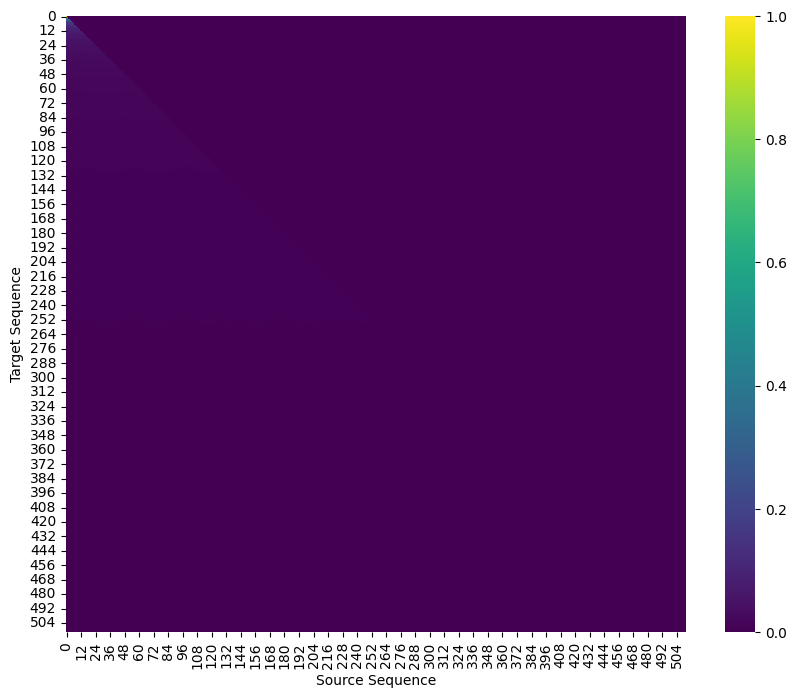

In [25]:
#attn_weights["layer1_dec_self"][0].shape
from matplotlib import pyplot as plt
import seaborn as sns
attn_weights_i = attn_weights["layer3_dec_self"][0].cpu().detach().numpy()
        
plt.figure(figsize=(10, 8))
sns.heatmap(attn_weights_i, cmap="viridis", cbar=True)
#plt.title(f"Attention Weights - Epoch {epoch}")
plt.xlabel("Source Sequence")
plt.ylabel("Target Sequence")
